# SABIO parameters

From the SabioReactionID 597 (ethanol DH).

In [1]:
import pandas as pd
from plotnine import *

In [2]:
df = pd.read_csv("../sabio597.tsv", sep="\t")

In [3]:
df.head()

,id,value,unit,species_name,pH,T
0,Act,0.000533,"CustomUnit(""molswedgeonegwedgeone"")",NaN,8.5,25.0
1,Kb_SPC_56_cytosol,0.000778,"CustomUnit(""M"")",Ethanol,9.0,25.0
2,Ka_SPC_37_cytosol,0.000036,"CustomUnit(""M"")",NAD+,9.0,25.0
3,Kia_SPC_37_cytosol,0.000040,"CustomUnit(""M"")",NAD+,9.0,25.0
4,kcat,4.900000,"CustomUnit(""swedgeone"")",NaN,9.0,25.0


In [4]:
df.head().to_latex()

'\\begin{tabular}{llrllrr}\n\\toprule\n{} &                  id &     value &                                 unit & species\\_name &   pH &     T \\\\\n\\midrule\n0 &                 Act &  0.000533 &  CustomUnit("molswedgeonegwedgeone") &          NaN &  8.5 &  25.0 \\\\\n1 &   Kb\\_SPC\\_56\\_cytosol &  0.000778 &                      CustomUnit("M") &      Ethanol &  9.0 &  25.0 \\\\\n2 &   Ka\\_SPC\\_37\\_cytosol &  0.000036 &                      CustomUnit("M") &         NAD+ &  9.0 &  25.0 \\\\\n3 &  Kia\\_SPC\\_37\\_cytosol &  0.000040 &                      CustomUnit("M") &         NAD+ &  9.0 &  25.0 \\\\\n4 &                kcat &  4.900000 &              CustomUnit("swedgeone") &          NaN &  9.0 &  25.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Parameter retrieval

In [5]:
kcats = df.loc[
    df.id.str.contains("kcat")
    & ~df.id.str.contains("Km")
    & (df.unit != 'CustomUnit("")'),
    :,
]
kcats.loc[:, "high"] = kcats.value > 15

/home/georg/.virtualenvs/maud/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
kms = df.loc[
    df.id.str.contains("Km") & ~df.id.str.contains("kcat") & ~df.id.str.contains("Vm"),
    :,
]

In [7]:
kms.head()

,id,value,unit,species_name,pH,T
8,Km_SPC_56_Cell,0.000150,"CustomUnit(""M"")",Ethanol,7.5,25.0
9,Km_SPC_37_cytoplasm,0.000039,"CustomUnit(""M"")",NAD+,8.5,25.0
11,Km_SPC_56_cytosol,0.040000,"CustomUnit(""M"")",Ethanol,7.5,25.0
18,Km_SPC_56_Cell,0.000580,"CustomUnit(""M"")",Ethanol,7.4,25.0
19,Km_SPC_38_mitochondrion,0.000025,"CustomUnit(""M"")",NADH,8.0,25.0


In [8]:
ids_spc = kms.id.str.split("SPC_", expand=True)
kms = kms.assign(id=ids_spc.iloc[:, 0], spc=ids_spc.iloc[:, 1])

In [9]:
kms["spc"] = kms.apply(lambda x: f"{x.species_name}_{x.spc.split('_')[1]}", axis=1)

### KMs plots

In [10]:
kms.head()

,id,value,unit,species_name,pH,T,spc
8,Km_,0.000150,"CustomUnit(""M"")",Ethanol,7.5,25.0,Ethanol_Cell
9,Km_,0.000039,"CustomUnit(""M"")",NAD+,8.5,25.0,NAD+_cytoplasm
11,Km_,0.040000,"CustomUnit(""M"")",Ethanol,7.5,25.0,Ethanol_cytosol
18,Km_,0.000580,"CustomUnit(""M"")",Ethanol,7.4,25.0,Ethanol_Cell
19,Km_,0.000025,"CustomUnit(""M"")",NADH,8.0,25.0,NADH_mitochondrion


/home/georg/.virtualenvs/maud/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 5 rows containing missing values.


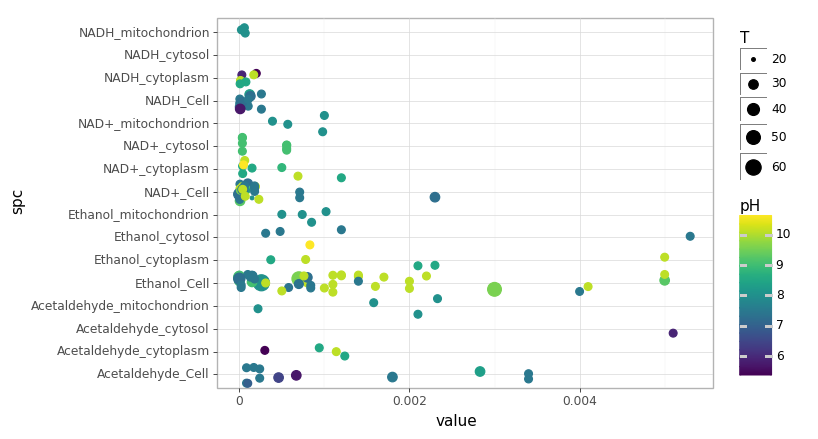

<ggplot: (8748328198937)>

In [11]:
(
    ggplot(kms[kms.value < 0.0055], aes("value", "spc", size="T", color="pH"))
    + geom_jitter()
    + theme_light()
)

In [12]:
kms[~kms.spc.str.contains("mito")].shape

(176, 7)

In [13]:
kms.shape

(192, 7)

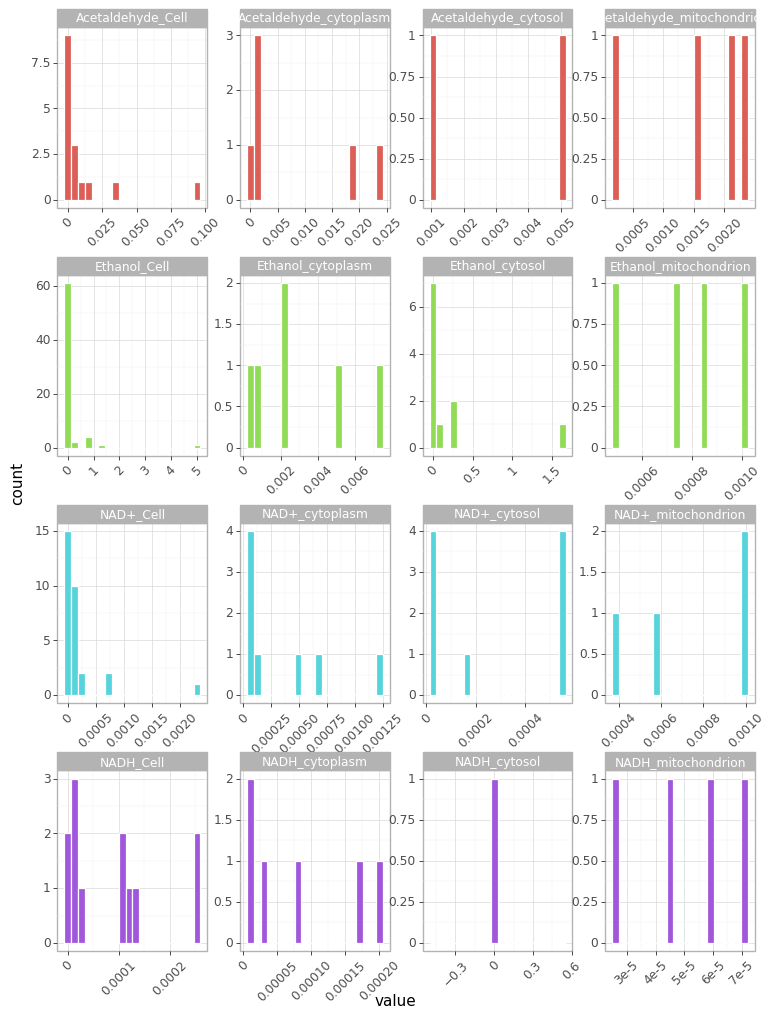

<ggplot: (8748324380588)>

In [14]:
(
    ggplot(kms, aes("value", fill="species_name"))
    + geom_histogram(color="white", bins=20)
    + theme_light()
    + theme(
        figure_size=(9, 12),
        subplots_adjust={"wspace": 0.22, "hspace": 0.37},
        axis_text_x=element_text(rotation=45),
    )
    + facet_wrap("~ spc", scales="free")
    + scale_fill_discrete(guide=False)
)

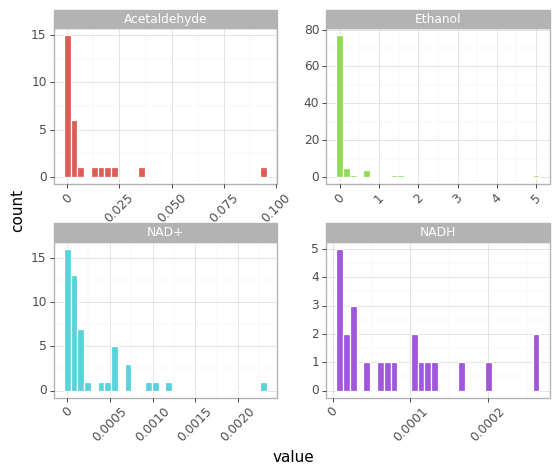

<ggplot: (8748319431141)>

In [15]:
(
    ggplot(kms, aes("value", fill="species_name"))
    + geom_histogram(bins=30, color="white")
    + theme_light()
    + theme(
        subplots_adjust={"wspace": 0.22, "hspace": 0.37},
        axis_text_x=element_text(rotation=45),
    )
    + facet_wrap("~ species_name", scales="free")
    + scale_fill_discrete(guide=False)
)

In [16]:
kms[~kms.spc.str.contains("itoch")][["species_name", "value"]].groupby(
    "species_name"
).apply(pd.DataFrame.mode)

species_name     value
species_name                          
Acetaldehyde 0  Acetaldehyde  0.000085
             1           NaN  0.000240
             2           NaN  0.003400
Ethanol      0       Ethanol  0.000000
             1           NaN  0.750000
NAD+         0          NAD+  0.000036
             1           NaN  0.000557
NADH         0          NADH  0.000006
             1           NaN  0.000105
             2           NaN  0.000260

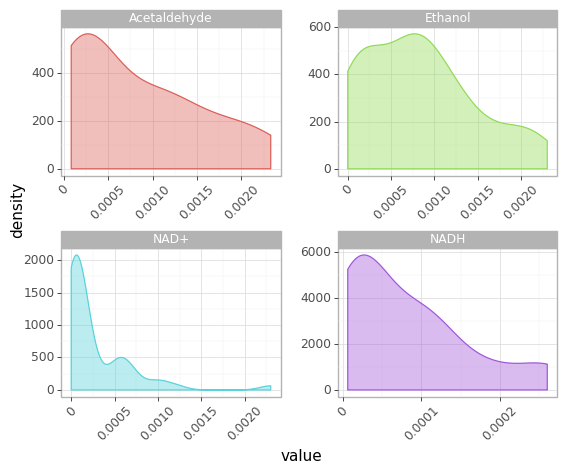

<ggplot: (8748319432361)>

In [17]:
(
    ggplot(
        kms[kms.value < 0.0025], aes("value", color="species_name", fill="species_name")
    )
    + geom_density(alpha=0.4)
    + theme_light()
    + theme(
        subplots_adjust={"wspace": 0.26, "hspace": 0.49},
        axis_text_x=element_text(rotation=45),
    )
    + facet_wrap("~ species_name", scales="free")
    + scale_fill_discrete(guide=False)
    + scale_color_discrete(guide=False)
)

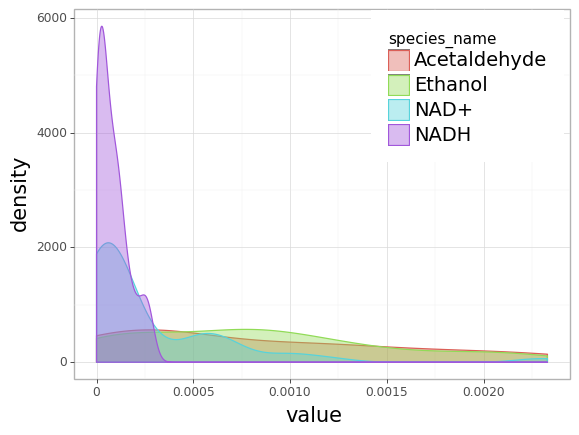

<ggplot: (8748319558789)>

In [18]:
(
    ggplot(
        kms[kms.value < 0.0025], aes("value", color="species_name", fill="species_name")
    )
    + geom_density(alpha=0.4)
    + theme_light()
    + theme(
        legend_position=(0.74, 0.72),
        axis_title_x=element_text(size=15),
        axis_title_y=element_text(size=15),
        legend_text=element_text(size=14),
    )
)

## Kcat plots

Separated and joined.

In [19]:
kcats.shape

(97, 7)

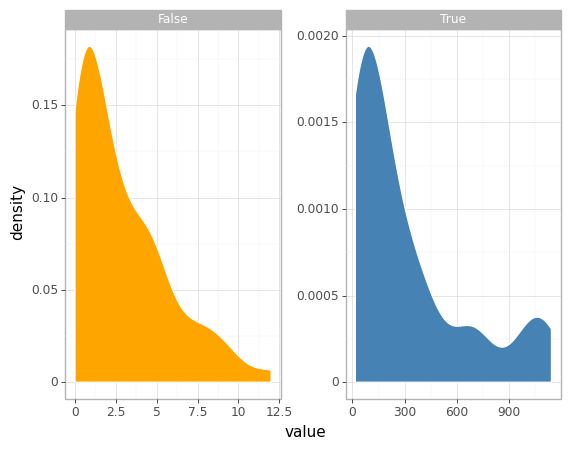

<ggplot: (8748319494906)>

In [20]:
(
    ggplot(kcats, aes("value", fill="high"))
    + geom_density(color="white")
    + facet_wrap("~ high", scales="free")
    + theme_light()
    + theme(subplots_adjust={"wspace": 0.3})
    + scale_fill_manual(guide=False, values=["orange", "steelblue"])
)

In [21]:
kcats.groupby("T").count()

,id,value,unit,species_name,pH,high
T,,,,,,
23.5,2,2,2,0,2,2
24.8,10,10,10,0,10,10
25.0,69,69,69,0,69,69
30.0,10,10,10,0,10,10
37.0,3,3,3,0,3,3
65.0,1,1,1,0,1,1


In [22]:
kcats.loc[:, "T"] = kcats["T"].apply(lambda x: str(x))
kcats.loc[:, "pH"] = kcats["pH"].apply(lambda x: str(x))

/home/georg/.virtualenvs/maud/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


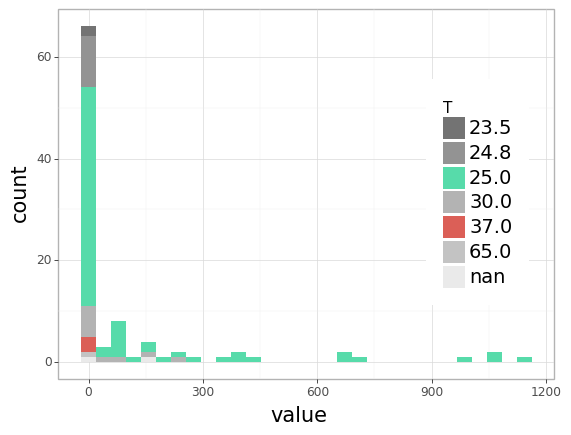

<ggplot: (8748319582564)>

In [23]:
(
    ggplot(kcats, aes("value", fill="T"))
    + geom_histogram(bins=30)
    + theme_light()
    + theme(
        legend_position=(0.78, 0.5),
        axis_title_x=element_text(size=15),
        axis_title_y=element_text(size=15),
        legend_text=element_text(size=14),
    )
    + scale_fill_manual(
        values=[
            "#737373",
            "#939393",
            "#57dbaa",
            "#b3b3b3",
            "#db5f57",
            "#c3c3c3",
            "#eaeaea",
        ]
    )
)

/home/georg/.virtualenvs/maud/lib/python3.9/site-packages/plotnine/stats/stat_density.py:151: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/home/georg/.virtualenvs/maud/lib/python3.9/site-packages/plotnine/stats/stat_density.py:154: PlotnineWarning: Groups with fewer than 2 data points have been removed.


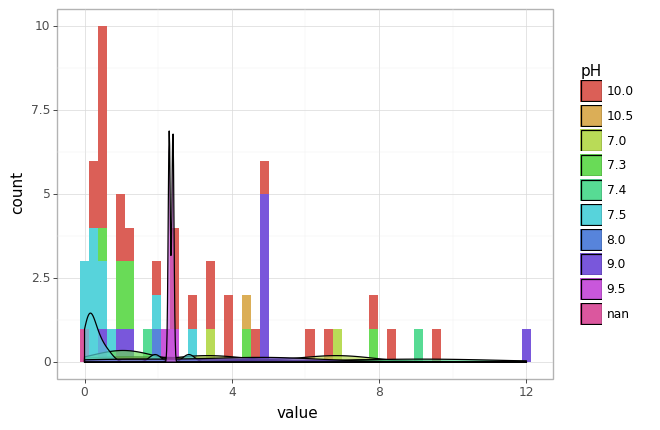

<ggplot: (8748319570676)>

In [24]:
(
    ggplot(kcats[~kcats.high], aes("value", fill="pH"))
    + geom_histogram(bins=50)
    + geom_density(alpha=0.7)
    + theme_light()
    + theme(subplots_adjust={"wspace": 0.3})
)